In [9]:
! pip install -q tensorflow-model-optimization

In [10]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard
import keras
import sys
import h5py
import numpy as np
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [12]:
!mkdir -p drive
!google-drive-ocamlfuse drive 
import os
os.chdir("/content/drive/MLsecurity_project") 

In [13]:
pip install -q tensorflow-model-optimization

# BadNet1: Sunglasses_BD_NET

In [109]:
SunModel = keras.models.load_model("/content/drive/MLsecurity_project/models/sunglasses_bd_net.h5")
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data']).astype(np.float32)
    y_data = np.array(data['label']).astype(np.float32)
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data
def data_preprocess(x_data):
    return x_data/255
clean_data_filename = "/content/drive/MLsecurity_project/data/clean_validation_data.h5"
X_train, Y_train = data_loader(clean_data_filename)
X_train = data_preprocess(X_train)
test_data_filename = "/content/drive/MLsecurity_project/data/clean_test_data.h5"
X_test, Y_test = data_loader(test_data_filename)
X_test = data_preprocess(X_test)

In [110]:
poison_data_filename = "/content/drive/MLsecurity_project/data/sunglasses_poisoned_data.h5"
xp, yp = data_loader(poison_data_filename)
xp = data_preprocess(xp)

In [111]:
SunModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

In [112]:
SunModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

## BadNet Evaluation

POISON DATA

In [113]:
SunBDPoison=[]
SunBDPoison.append(SunModel.evaluate(xp,yp)[1])
SunBDPoison

401/401 [==============================] - 2s 3ms/step - loss: 4.7541e-04 - accuracy: 1.0000


[0.9999220371246338]

In [114]:
np.argmax(SunModel.predict(xp),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

CLEAN TEST DATA

In [115]:
SunBDClean=[]
SunBDClean.append(SunModel.evaluate(X_test,Y_test)[1])
SunBDClean

401/401 [==============================] - 1s 3ms/step - loss: 0.4011 - accuracy: 0.9778


[0.9777864217758179]

In [116]:
np.argmax(SunModel.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

## Activations of the last hidden layer projected onto the TOP principle components.

In [117]:
from keras.models import Model

model1= Model(inputs=SunModel.input, outputs=SunModel.layers[-6].output)
model1.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0   

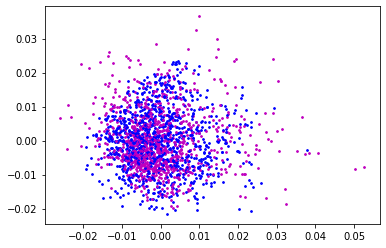

In [118]:
clean_output1 = model1.predict(X_train)
p_output1 = model1.predict(xp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
S_ = ica.fit_transform(clean_output1)
S1_ = ica.fit_transform(p_output1)

clean_output1=pca.fit_transform(clean_output1)
p_output1=pca.fit_transform(p_output1)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=S_[j][0]
    # print(len(y[0]))
    x =S_[j][1]
    y1=S1_[j][0]
    x1 = S1_[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [119]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(SunModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [120]:
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv_1 (Pru (None, 52, 44, 20)   1942        input[0][0]                      
__________________________________________________________________________________________________
prune_low_magnitude_pool_1 (Pru (None, 26, 22, 20)   1           prune_low_magnitude_conv_1[0][0] 
__________________________________________________________________________________________________
prune_low_magnitude_conv_2 (Pru (None, 24, 20, 40)   14442       prune_low_magnitude_pool_1[0][0] 
____________________________________________________________________________________________

### Pruning Evaluation

POISON DATA

In [121]:
SunBDPoison.append(model_for_pruning.evaluate(xp,yp)[1])
SunBDPoison

401/401 [==============================] - 2s 4ms/step - loss: 4.7541e-04 - accuracy: 1.0000


[0.9999220371246338, 0.9999220371246338]

In [122]:
np.argmax(SunModel.predict(xp),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

CLEAN TEST DATA

In [123]:
SunBDClean.append(model_for_pruning.evaluate(X_test,Y_test)[1])
SunBDClean

401/401 [==============================] - 1s 3ms/step - loss: 0.4011 - accuracy: 0.9778


[0.9777864217758179, 0.9777864217758179]

In [124]:
np.argmax(model_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

### Fine Tune

In [125]:
model_for_pruning.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 5s 29ms/step - loss: 0.5346 - accuracy: 0.9078 - val_loss: 0.3621 - val_accuracy: 0.9325
Epoch 2/10
82/82 [==============================] - 2s 24ms/step - loss: 0.1352 - accuracy: 0.9783 - val_loss: 0.3544 - val_accuracy: 0.9429
Epoch 3/10
82/82 [==============================] - 2s 29ms/step - loss: 0.0635 - accuracy: 0.9893 - val_loss: 0.4050 - val_accuracy: 0.9394
Epoch 4/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0288 - accuracy: 0.9938 - val_loss: 0.4013 - val_accuracy: 0.9455
Epoch 5/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0157 - accuracy: 0.9967 - val_loss: 0.4299 - val_accuracy: 0.9394
Epoch 6/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 0.4517 - val_accuracy: 0.9411
Epoch 7/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0127 - accuracy: 0.9973 - val_loss: 0.4516 - val_accuracy: 0.9411
Epoch 8/10
82

In [126]:
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv_1 (Pru (None, 52, 44, 20)   1942        input[0][0]                      
__________________________________________________________________________________________________
prune_low_magnitude_pool_1 (Pru (None, 26, 22, 20)   1           prune_low_magnitude_conv_1[0][0] 
__________________________________________________________________________________________________
prune_low_magnitude_conv_2 (Pru (None, 24, 20, 40)   14442       prune_low_magnitude_pool_1[0][0] 
____________________________________________________________________________________________

## Fine Pruning Evaluation

Poison Data

In [127]:
np.argmax(model_for_pruning.predict(xp),axis=1)

array([485,  16, 977, ...,   0, 448, 333])

In [128]:
SunBDPoison.append(model_for_pruning.evaluate(xp,yp)[1])

401/401 [==============================] - 1s 3ms/step - loss: 3.7417 - accuracy: 0.3985


Clean Test Data

In [129]:
np.argmax(model_for_pruning.predict(X_test),axis=1)

array([950, 992, 415, ..., 406, 304, 872])

In [130]:
SunBDClean.append(model_for_pruning.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.6075 - accuracy: 0.8959


## Reconstruct model by adding layer

N+1 Classes

In [131]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

model2= Model(inputs=model_for_pruning.input, outputs=model_for_pruning.layers[-2].output)
# model2.summary()
model3 = Sequential()
model3.add(model2)
model3.add(Dense(1284, activation='softmax'))
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_9 (Functional)         (None, 160)               789659    
_________________________________________________________________
dense_4 (Dense)              (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [132]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

model3.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 30ms/step - loss: 10.4348 - accuracy: 0.0018 - val_loss: 7.0595 - val_accuracy: 0.0078
Epoch 2/10
82/82 [==============================] - 2s 23ms/step - loss: 6.8619 - accuracy: 0.0127 - val_loss: 6.3166 - val_accuracy: 0.0433
Epoch 3/10
82/82 [==============================] - 2s 23ms/step - loss: 5.5767 - accuracy: 0.0972 - val_loss: 4.9177 - val_accuracy: 0.1948
Epoch 4/10
82/82 [==============================] - 2s 23ms/step - loss: 3.4964 - accuracy: 0.3534 - val_loss: 3.6107 - val_accuracy: 0.4320
Epoch 5/10
82/82 [==============================] - 2s 23ms/step - loss: 1.9994 - accuracy: 0.6060 - val_loss: 2.9806 - val_accuracy: 0.5584
Epoch 6/10
82/82 [==============================] - 2s 23ms/step - loss: 1.0757 - accuracy: 0.7819 - val_loss: 2.6904 - val_accuracy: 0.6286
Epoch 7/10
82/82 [==============================] - 2s 23ms/step - loss: 0.6314 - accuracy: 0.8617 - val_loss: 2.6018 - val_accuracy: 0.6831
Epoch 8/10
8

## New Model Evaluation 

Clean Test Data

In [133]:
np.argmax(model3.predict(X_test),axis=1)

array([950, 992, 977, ..., 770, 304, 872])

In [134]:
SunBDClean.append(model3.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 4ms/step - loss: 2.7548 - accuracy: 0.7542


Poison data

In [135]:
np.argmax(model3.predict(xp),axis=1)

array([ 853,  440,  977, ...,  570, 1054,  879])

In [136]:
SunBDPoison.append(model3.evaluate(xp,yp)[1])

401/401 [==============================] - 2s 4ms/step - loss: 35.8150 - accuracy: 0.0000e+00


Conclusion : Low Accuracy---it couldn't  predict successfully

## Fine Pruning Comparison Data

In [137]:
sp=0.55
SunBDPoisonCompP=[]
SunBDPoisonCompFP=[]
SunBDCleanCompP=[]
SunBDCleanCompFP=[]
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

for i in range(8):
  SunModel = keras.models.load_model("/content/drive/MLsecurity_project/models/sunglasses_bd_net.h5")
  SunModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
  sp=sp+0.05
  print(sp)
  # Define model for pruning.
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=sp,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  model_for_pruningComp = prune_low_magnitude(SunModel, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruningComp.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer=Adam(), metrics=['accuracy'])


  #model_for_pruning.summary()
  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  #Evaluation
  SunBDPoisonCompP.append(model_for_pruningComp.evaluate(xp,yp)[1])
  print("Pruning",SunBDPoisonCompP)
  SunBDCleanCompP.append(model_for_pruningComp.evaluate(X_test,Y_test)[1])
  print(SunBDCleanCompP)
  model_for_pruningComp.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)
  SunBDPoisonCompFP.append(model_for_pruningComp.evaluate(xp,yp)[1])
  print("Fine-Pruning",SunBDPoisonCompFP)
  SunBDCleanCompFP.append(model_for_pruningComp.evaluate(X_test,Y_test)[1])
  print(SunBDCleanCompFP)

0.6000000000000001


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


401/401 [==============================] - 2s 4ms/step - loss: 4.7541e-04 - accuracy: 1.0000
Pruning [0.9999220371246338]
401/401 [==============================] - 1s 4ms/step - loss: 0.4011 - accuracy: 0.9778
[0.9777864217758179]
Epoch 1/10
82/82 [==============================] - 5s 30ms/step - loss: 0.5346 - accuracy: 0.9065 - val_loss: 0.3709 - val_accuracy: 0.9290
Epoch 2/10
82/82 [==============================] - 2s 29ms/step - loss: 0.3227 - accuracy: 0.9269 - val_loss: 0.5120 - val_accuracy: 0.9108
Epoch 3/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0723 - accuracy: 0.9863 - val_loss: 0.4573 - val_accuracy: 0.9264
Epoch 4/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0234 - accuracy: 0.9960 - val_loss: 0.4521 - val_accuracy: 0.9281
Epoch 5/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.4707 - val_accuracy: 0.9299
Epoch 6/10
82/82 [==============================] - 2s 24ms/ste

# BadNet2: Anonymous1_BD_Net

In [138]:
AnonyModel = keras.models.load_model("/content/drive/MLsecurity_project/models/anonymous_1_bd_net.h5")
AnonyModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

In [139]:
Anonypoison_data_filename = "/content/drive/MLsecurity_project/data/anonymous_1_poisoned_data.h5"
Anonyxp, Anonyyp = data_loader(Anonypoison_data_filename)
Anonyxp = data_preprocess(Anonyxp)

In [140]:
AnonyModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

## BadNet2 Evaluation

In [141]:
AnonyPoison=[]
AnonyPoison.append(AnonyModel.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 0.8944 - accuracy: 0.9148


In [142]:
np.argmax(AnonyModel.predict(Anonyxp),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [143]:
AnonyClean=[]
AnonyClean.append(AnonyModel.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.3028 - accuracy: 0.9719


In [144]:
np.argmax(AnonyModel.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

## Activations of the last hidden layer projected onto the TOP principle components.

In [145]:
from keras.models import Model

AnonyModel1= Model(inputs=AnonyModel.input, outputs=AnonyModel.layers[-6].output)
AnonyModel1.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0  

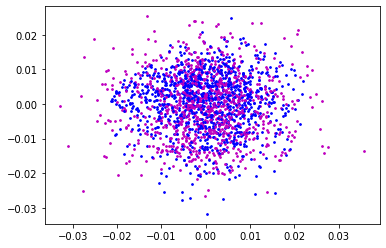

In [146]:
Anonyclean_output1 = AnonyModel1.predict(X_train)
Anonyp_output1 = AnonyModel1.predict(xp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
AnonyS_ = ica.fit_transform(Anonyclean_output1)
AnonyS1_ = ica.fit_transform(Anonyp_output1)

Anonyclean_output1=pca.fit_transform(Anonyclean_output1)
Anonyp_output1=pca.fit_transform(Anonyp_output1)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=AnonyS_[j][0]
    # print(len(y[0]))
    x =AnonyS_[j][1]
    y1=AnonyS1_[j][0]
    x1 = AnonyS1_[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [147]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

Anonymodel_for_pruning = prune_low_magnitude(AnonyModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
Anonymodel_for_pruning.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Pruning Evaluation

In [148]:
AnonyPoison.append(Anonymodel_for_pruning.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 2s 4ms/step - loss: 0.8944 - accuracy: 0.9148


In [149]:
np.argmax(Anonymodel_for_pruning.predict(Anonyxp),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

CLEAN TEST DATA

In [150]:
AnonyClean.append(Anonymodel_for_pruning.evaluate(X_test,Y_test)[1])
AnonyClean

401/401 [==============================] - 1s 3ms/step - loss: 0.3028 - accuracy: 0.9719


[0.97186279296875, 0.97186279296875]

In [151]:
np.argmax(Anonymodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

### Fine Tune

In [152]:
Anonymodel_for_pruning.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 6s 30ms/step - loss: 0.3484 - accuracy: 0.9368 - val_loss: 0.2511 - val_accuracy: 0.9558
Epoch 2/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0904 - accuracy: 0.9862 - val_loss: 0.2362 - val_accuracy: 0.9567
Epoch 3/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0374 - accuracy: 0.9951 - val_loss: 0.2082 - val_accuracy: 0.9619
Epoch 4/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0165 - accuracy: 0.9973 - val_loss: 0.2193 - val_accuracy: 0.9610
Epoch 5/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0074 - accuracy: 0.9986 - val_loss: 0.2279 - val_accuracy: 0.9645
Epoch 6/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.2119 - val_accuracy: 0.9610
Epoch 7/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.2195 - val_accuracy: 0.9680
Epoch 8/10
82

## Fine Pruning Evaluation

Poison Data

In [153]:
AnonyPoison.append(Anonymodel_for_pruning.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 1.8022 - accuracy: 0.8582


In [154]:
np.argmax(Anonymodel_for_pruning.predict(Anonyxp),axis=1)

array([  0,   0, 189, ...,   0,   0,   0])

Clean Test Data

In [155]:
np.argmax(Anonymodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

In [156]:
AnonyClean.append(Anonymodel_for_pruning.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.2200 - accuracy: 0.9670


## Reconstruct model by adding layer

N+1 Classes

In [157]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

Anonymodel2= Model(inputs=Anonymodel_for_pruning.input, outputs=Anonymodel_for_pruning.layers[-2].output)
# model2.summary()
Anonymodel3 = Sequential()
Anonymodel3.add(Anonymodel2)
Anonymodel3.add(Dense(1284, activation='softmax'))
Anonymodel3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
Anonymodel3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_11 (Functional)        (None, 160)               789659    
_________________________________________________________________
dense_5 (Dense)              (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [158]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

Anonymodel3.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 34ms/step - loss: 9.9205 - accuracy: 0.0033 - val_loss: 6.7634 - val_accuracy: 0.0147
Epoch 2/10
82/82 [==============================] - 2s 23ms/step - loss: 6.1763 - accuracy: 0.0478 - val_loss: 4.5943 - val_accuracy: 0.2589
Epoch 3/10
82/82 [==============================] - 2s 23ms/step - loss: 2.9136 - accuracy: 0.4676 - val_loss: 2.7254 - val_accuracy: 0.5714
Epoch 4/10
82/82 [==============================] - 2s 22ms/step - loss: 1.0920 - accuracy: 0.7828 - val_loss: 2.1275 - val_accuracy: 0.6987
Epoch 5/10
82/82 [==============================] - 2s 22ms/step - loss: 0.4668 - accuracy: 0.9062 - val_loss: 1.9550 - val_accuracy: 0.7446
Epoch 6/10
82/82 [==============================] - 2s 22ms/step - loss: 0.1846 - accuracy: 0.9621 - val_loss: 1.9929 - val_accuracy: 0.7662
Epoch 7/10
82/82 [==============================] - 2s 23ms/step - loss: 0.0730 - accuracy: 0.9867 - val_loss: 2.0614 - val_accuracy: 0.7844
Epoch 8/10
82

## New Model Evaluation 

Clean Test Data

In [159]:
np.argmax(Anonymodel3.predict(X_test),axis=1)

array([950, 992, 977, ..., 770, 304, 872])

In [160]:
AnonyClean.append(Anonymodel3.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.2077 - accuracy: 0.8097


Poison data

In [161]:
AnonyPoison.append(Anonymodel3.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 29.5058 - accuracy: 0.0094


# BadNet2: Anonymous2_BD_Net

In [162]:
AnonyModel2 = keras.models.load_model("/content/drive/MLsecurity_project/models/anonymous_2_bd_net.h5")
AnonyModel2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

In [163]:
AnonyModel2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

## BadNet2 Evaluation

In [164]:
AnonyClean2=[]
AnonyClean2.append(AnonyModel2.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 2s 3ms/step - loss: 0.2915 - accuracy: 0.9575


In [165]:
np.argmax(AnonyModel2.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304,   4])

## Activations of the last hidden layer projected onto the TOP principle components.

In [166]:
from keras.models import Model

AnonyModel1_2= Model(inputs=AnonyModel2.input, outputs=AnonyModel2.layers[-6].output)
AnonyModel1_2.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0  

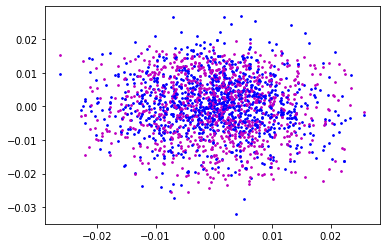

In [167]:
Anonyclean_output1_2 = AnonyModel1_2.predict(X_train)
Anonyp_output1_2 = AnonyModel1_2.predict(xp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
AnonyS_2 = ica.fit_transform(Anonyclean_output1_2)
AnonyS1_2 = ica.fit_transform(Anonyp_output1_2)

Anonyclean_output1_2=pca.fit_transform(Anonyclean_output1_2)
Anonyp_output1_2=pca.fit_transform(Anonyp_output1_2)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=AnonyS_2[j][0]
    # print(len(y[0]))
    x =AnonyS1_2[j][1]
    y1=AnonyS1_2[j][0]
    x1 = AnonyS1_2[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [168]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

Anonymodel_for_pruning2 = prune_low_magnitude(AnonyModel2, **pruning_params)

# `prune_low_magnitude` requires a recompile.
Anonymodel_for_pruning2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Pruning Evaluation

CLEAN TEST DATA

In [169]:
AnonyClean2.append(Anonymodel_for_pruning2.evaluate(X_test,Y_test)[1])
AnonyClean2

401/401 [==============================] - 2s 3ms/step - loss: 0.2915 - accuracy: 0.9575


[0.9596258997917175, 0.9596258997917175]

In [170]:
np.argmax(Anonymodel_for_pruning2.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304,   4])

### Fine Tune

In [171]:
Anonymodel_for_pruning2.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 5s 30ms/step - loss: 0.3105 - accuracy: 0.9304 - val_loss: 0.2241 - val_accuracy: 0.9506
Epoch 2/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0521 - accuracy: 0.9877 - val_loss: 0.1998 - val_accuracy: 0.9558
Epoch 3/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.2047 - val_accuracy: 0.9584
Epoch 4/10
82/82 [==============================] - 2s 29ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.1932 - val_accuracy: 0.9645
Epoch 5/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1909 - val_accuracy: 0.9628
Epoch 6/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.1920 - val_accuracy: 0.9619
Epoch 7/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.1923 - val_accuracy: 0.9628
Epoch 8/10
82

## Fine Pruning Evaluation

Clean Test Data

In [172]:
np.argmax(Anonymodel_for_pruning2.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 480])

In [173]:
AnonyClean2.append(Anonymodel_for_pruning2.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.1779 - accuracy: 0.9686


## Reconstruct model by adding layer

N+1 Classes

In [174]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

Anonymodel2_2= Model(inputs=Anonymodel_for_pruning2.input, outputs=Anonymodel_for_pruning2.layers[-2].output)
# model2.summary()
Anonymodel3_2 = Sequential()
Anonymodel3_2.add(Anonymodel2)
Anonymodel3_2.add(Dense(1284, activation='softmax'))
Anonymodel3_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
Anonymodel3_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_11 (Functional)        (None, 160)               789659    
_________________________________________________________________
dense_6 (Dense)              (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [175]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

Anonymodel3_2.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 29ms/step - loss: 9.3945 - accuracy: 0.0046 - val_loss: 6.7337 - val_accuracy: 0.0182
Epoch 2/10
82/82 [==============================] - 2s 23ms/step - loss: 5.7982 - accuracy: 0.0815 - val_loss: 4.2283 - val_accuracy: 0.3013
Epoch 3/10
82/82 [==============================] - 2s 23ms/step - loss: 2.3563 - accuracy: 0.5463 - val_loss: 2.4584 - val_accuracy: 0.6208
Epoch 4/10
82/82 [==============================] - 2s 23ms/step - loss: 0.7106 - accuracy: 0.8474 - val_loss: 1.9389 - val_accuracy: 0.7221
Epoch 5/10
82/82 [==============================] - 2s 22ms/step - loss: 0.2056 - accuracy: 0.9546 - val_loss: 1.9181 - val_accuracy: 0.7576
Epoch 6/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0631 - accuracy: 0.9869 - val_loss: 1.9587 - val_accuracy: 0.7879
Epoch 7/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0158 - accuracy: 0.9979 - val_loss: 2.0388 - val_accuracy: 0.8017
Epoch 8/10
82

## New Model Evaluation 

Clean Test Data

In [176]:
np.argmax(Anonymodel3_2.predict(X_test),axis=1)

array([950, 992,  64, ..., 770, 304, 872])

In [177]:
AnonyClean2.append(Anonymodel3_2.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.0476 - accuracy: 0.8169


# BadNet3: multi_trigger_multi_target_bd_net

In [178]:
MultiModel = keras.models.load_model("/content/drive/MLsecurity_project/models/multi_trigger_multi_target_bd_net.h5")

In [179]:
Multipoison_data_filename = "/content/drive/MLsecurity_project/data/eyebrows_poisoned_data.h5"
Multixp, Multiyp = data_loader(Multipoison_data_filename)
Multixp = data_preprocess(Multixp)

In [180]:
MultiModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

## BadNet Evaluation

POISON DATA

In [181]:
MultiBDPoison=[]
MultiBDClean=[]
MultiBDPoison.append(MultiModel.evaluate(Multixp,Multiyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 1.0021 - accuracy: 0.9139


In [182]:
np.argmax(MultiModel.predict(Multixp),axis=1)

array([5, 5, 5, ..., 5, 5, 5])

CLEAN TEST DATA

In [183]:
MultiBDClean.append(MultiModel.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.2382 - accuracy: 0.9601


In [184]:
np.argmax(MultiModel.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

## Activations of the last hidden layer projected onto the TOP principle components.

In [185]:
from keras.models import Model

Multimodel1= Model(inputs=MultiModel.input, outputs=MultiModel.layers[-6].output)
Multimodel1.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0  

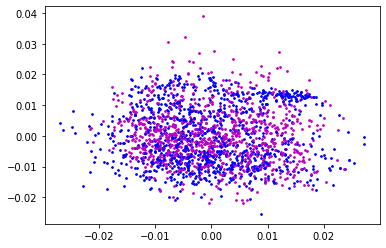

In [186]:
Multiclean_output1 = Multimodel1.predict(X_train)
Multip_output1 = Multimodel1.predict(Multixp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
MultiS_ = ica.fit_transform(Multiclean_output1)
MultiS1_ = ica.fit_transform(Multip_output1)

Multiclean_output1=pca.fit_transform(Multiclean_output1)
Multip_output1=pca.fit_transform(Multip_output1)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=MultiS_[j][0]
    # print(len(y[0]))
    x =MultiS_[j][1]
    y1=MultiS1_[j][0]
    x1 = MultiS1_[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [187]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

Multimodel_for_pruning = prune_low_magnitude(MultiModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
Multimodel_for_pruning.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Pruning Evaluation

POISON DATA

In [188]:
MultiBDPoison.append(Multimodel_for_pruning.evaluate(xp,yp)[1])
MultiBDPoison

401/401 [==============================] - 2s 3ms/step - loss: 119.2049 - accuracy: 0.0000e+00


[0.9134840369224548, 0.0]

In [189]:
np.argmax(Multimodel_for_pruning.predict(xp),axis=1)

array([8, 8, 8, ..., 8, 8, 8])

CLEAN TEST DATA

In [190]:
MultiBDClean.append(Multimodel_for_pruning.evaluate(X_test,Y_test)[1])
MultiBDClean

401/401 [==============================] - 1s 3ms/step - loss: 0.2382 - accuracy: 0.9601


[0.9600935578346252, 0.9600935578346252]

In [191]:
np.argmax(Multimodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

### Fine Tune

In [192]:
Multimodel_for_pruning.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 6s 36ms/step - loss: 0.3080 - accuracy: 0.9344 - val_loss: 0.2262 - val_accuracy: 0.9394
Epoch 2/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0575 - accuracy: 0.9870 - val_loss: 0.2274 - val_accuracy: 0.9429
Epoch 3/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0207 - accuracy: 0.9950 - val_loss: 0.2300 - val_accuracy: 0.9472
Epoch 4/10
82/82 [==============================] - 2s 24ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.2196 - val_accuracy: 0.9532
Epoch 5/10
82/82 [==============================] - 2s 23ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.2129 - val_accuracy: 0.9567
Epoch 6/10
82/82 [==============================] - 2s 23ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.2120 - val_accuracy: 0.9576
Epoch 7/10
82/82 [==============================] - 2s 23ms/step - loss: 0.0019 - accuracy: 0.9990 - val_loss: 0.2086 - val_accuracy: 0.9567
Epoch 8/10
82

## Fine Pruning Evaluation

Poison Data

In [193]:
np.argmax(Multimodel_for_pruning.predict(Multixp),axis=1)

array([   5,  903, 1004, ...,    5,    5,    5])

In [194]:
MultiBDPoison.append(Multimodel_for_pruning.evaluate(Multixp,Multiyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 3.2269 - accuracy: 0.7385


Clean Test Data

In [195]:
np.argmax(Multimodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

In [196]:
MultiBDClean.append(Multimodel_for_pruning.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.2134 - accuracy: 0.9617


## Reconstruct model by adding layer

N+1 Classes

In [197]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

Multimodel2= Model(inputs=Multimodel_for_pruning.input, outputs=Multimodel_for_pruning.layers[-2].output)
# model2.summary()
Multimodel3 = Sequential()
Multimodel3.add(model2)
Multimodel3.add(Dense(1284, activation='softmax'))
Multimodel3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
Multimodel3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_9 (Functional)         (None, 160)               789659    
_________________________________________________________________
dense_7 (Dense)              (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [198]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

Multimodel3.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 29ms/step - loss: 9.0524 - accuracy: 0.0029 - val_loss: 6.8610 - val_accuracy: 0.0165
Epoch 2/10
82/82 [==============================] - 2s 22ms/step - loss: 6.4032 - accuracy: 0.0476 - val_loss: 5.2878 - val_accuracy: 0.1567
Epoch 3/10
82/82 [==============================] - 2s 22ms/step - loss: 3.9842 - accuracy: 0.3034 - val_loss: 3.4196 - val_accuracy: 0.4597
Epoch 4/10
82/82 [==============================] - 2s 22ms/step - loss: 1.6749 - accuracy: 0.6644 - val_loss: 2.5378 - val_accuracy: 0.6398
Epoch 5/10
82/82 [==============================] - 2s 22ms/step - loss: 0.7188 - accuracy: 0.8479 - val_loss: 2.2155 - val_accuracy: 0.7203
Epoch 6/10
82/82 [==============================] - 2s 22ms/step - loss: 0.2879 - accuracy: 0.9368 - val_loss: 2.2649 - val_accuracy: 0.7342
Epoch 7/10
82/82 [==============================] - 2s 22ms/step - loss: 0.1286 - accuracy: 0.9707 - val_loss: 2.4000 - val_accuracy: 0.7437
Epoch 8/10
82

## New Model Evaluation 

Clean Test Data

In [199]:
np.argmax(Multimodel3.predict(X_test),axis=1)

array([950, 992, 764, ..., 770, 304, 872])

In [200]:
MultiBDClean.append(Multimodel3.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.4691 - accuracy: 0.7973


Poison data

In [201]:
np.argmax(Multimodel3.predict(Multixp),axis=1)

array([500, 741, 212, ..., 328,  80,  48])

In [202]:
MultiBDPoison.append(Multimodel3.evaluate(Multixp,Multiyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 46.0879 - accuracy: 3.8971e-04


Conclusion : Low Accuracy---it couldn't  predict successfully

# Analysis

In [203]:
import pandas as pd
data = [SunBDPoison,SunBDClean,AnonyPoison,AnonyClean,AnonyClean2,MultiBDPoison,MultiBDClean]
DF = pd.DataFrame(data, columns=[" BadNet ","Pruning"," Fine-Pruning  ","Reconstruct Model"])
DF.index = ['Sunglasses Poison Data','Sunglasses Clean Data','Anonymous Poison Data','Anonymous Clean Data','Anonymous2 Clean Data','Multi-Trigger Poison Data','Multi-Trigger Clean Data']
DF

,BadNet,Pruning,Fine-Pruning,Reconstruct Model
Sunglasses Poison Data,0.999922,0.999922,0.398519,0.000000
Sunglasses Clean Data,0.977786,0.977786,0.895947,0.754170
Anonymous Poison Data,0.913971,0.913971,0.858242,0.009353
Anonymous Clean Data,0.971863,0.971863,0.967030,0.809665
Anonymous2 Clean Data,0.959626,0.959626,0.968589,0.816913
Multi-Trigger Poison Data,0.913484,0.000000,0.738504,0.000390
Multi-Trigger Clean Data,0.960094,0.960094,0.961652,0.797350
